# K-Means Analysis

### Importing Libraries

In [ ]:
############################### Database Connections ######################################

import pymssql
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import sqlalchemy
from sqlalchemy  import create_engine
import matplotlib.pyplot as plt

### Database Connections

In [2]:
# AWS
server = 'pfidb.ci3ir6nuotoi.sa-east-1.rds.amazonaws.com'
user = 'admin'
password = 'AramLucas2020.'
db = 'pfidb'

# Connection to DB
conn = pymssql.connect(server,user,password,db)

## Script

In [3]:
#Query that retrives the stations
stations_query = """SELECT * FROM [estaciones-de-bicicletas-publicas]"""
df_stations = pd.read_sql(stations_query,conn)
df_stations.head()

,long,lat,nombre,domicilio,nro_est,dire_norm,capacidad
0,-58.392452,-34.583133,Facultad de Derecho,Av. Pres.Figueroa Alcorta y Juan A.Bibiloni,1,"FIGUEROA ALCORTA, PRES. AV. y BIBILONI, JUAN A.",20
1,-58.374822,-34.592589,Retiro,Av. Dr.Jose Ramos Mejia y Del Libertador Av,2,"DEL LIBERTADOR AV. y RAMOS MEJIA, JOSE MARIA, ...",12
2,-58.368918,-34.611242,Aduana,Av. Ing.Huergo y Av. Belgrano,3,"HUERGO, ING. AV. y BELGRANO AV.",12
3,-58.368950,-34.601721,Plaza Roma,Lavalle y Bouchard,4,LAVALLE y BOUCHARD,12
4,-58.420997,-34.580127,Plaza Italia,Av. Santa Fe y Av. Sarmiento,5,SARMIENTO AV. y CALZADA CIRCULAR PLAZA ITALIA,42


In [4]:
# Calculating KMeans n times. n represents the amount of stations of the current system
lat_long = df_stations[["lat", "long"]].values
sse_df = pd.DataFrame(columns=['K','sse'])
sse = {}
for k in range(1, int(len(df_stations))+1):
    kmeans = KMeans(n_clusters=k,random_state=0,max_iter=1000).fit(lat_long)
    sse_df = sse_df.append({'K':k, 'sse':kmeans.inertia_},ignore_index=True)
    sse[k] = kmeans.inertia_
sse_df

,K,sse
0,1.0,1.629138e-01
1,2.0,7.730877e-02
2,3.0,5.251126e-02
3,4.0,3.890237e-02
4,5.0,3.002154e-02
...,...,...
195,196.0,5.937185e-07
196,197.0,5.175386e-08
197,198.0,1.608660e-08
198,199.0,7.270601e-09


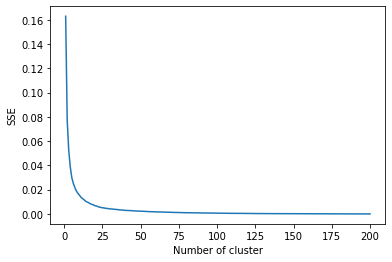

In [5]:
# Plotting the elbow method using SSE (sum of squared estimate of errors) 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [6]:
# Setting upper and lower limit to use the best K calculated a few steps before.
# The lower limit is picked by analyzing the percentage of change of sse's. When the variation is greater or equal to 10%
# we establish that K value as the lower limit.
# The upper limit is decided by adding the 10% of the total amount of stations to the lower limit.
sse_df['variation'] = (sse_df['sse'].pct_change())*-1
i = sse_df.loc[(sse_df['variation'] <= 0.1)].index[0]
lower_limit = int(sse_df.iloc[i]['K'])
upper_limit = int(lower_limit  + round((len(df_stations)*0.1)))
print(upper_limit)

30


In [7]:
print(sse_df.loc[(sse_df['variation'] <= 0.1)])

         K       sse  variation
9     10.0  0.015457   0.089083
11    12.0  0.012708   0.072381
12    13.0  0.011722   0.077622
14    15.0  0.009813   0.069602
15    16.0  0.009304   0.051833
..     ...       ...        ...
174  175.0  0.000042   0.093002
176  177.0  0.000037  -0.013686
179  180.0  0.000026   0.079028
180  181.0  0.000023   0.099051
181  182.0  0.000021   0.092609

[167 rows x 3 columns]


In [8]:
silhouette = pd.DataFrame(columns=['cluster','sil_coeff'])
for n_cluster in range(lower_limit, upper_limit):
    kmeans = KMeans(n_clusters=n_cluster,random_state=0).fit(lat_long)
    label = kmeans.labels_
    sil_coeff = silhouette_score(lat_long, label, metric='euclidean')
    silhouette = silhouette.append({'cluster':n_cluster, 'sil_coeff':sil_coeff},ignore_index=True)
    #print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
silhouette

,cluster,sil_coeff
0,10.0,0.355409
1,11.0,0.343335
2,12.0,0.328058
3,13.0,0.329516
4,14.0,0.336909
5,15.0,0.348696
6,16.0,0.328035
7,17.0,0.335490
8,18.0,0.333986
9,19.0,0.332817


In [9]:
# silhouette.loc[silhouette['sil_coeff'].idxmax()]['cluster']
#silhouette['sil_coeff'].idxmax()
silhouette.sort_values('sil_coeff',ascending=False,inplace=True)
selected_k = silhouette.loc[silhouette['cluster']>=24]['cluster'].iloc[0] # 24 is the amount of barrios where a station is available
print(selected_k)
# print([cluster for cluster in silhouette if silhouette['cluster'].values >15])

23.0


Automatically created module for IPython interactive environment
For n_clusters = 23 The average silhouette_score is : 0.36695018120091727


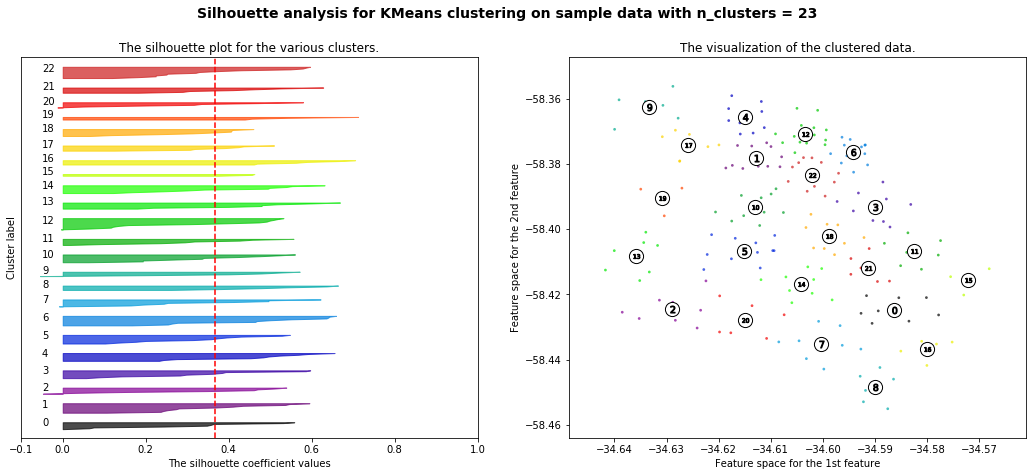

In [10]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
k_to_use = int(selected_k)
range_n_clusters = [k_to_use]
X = df_stations[["lat", "long"]].values

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()